In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/learn-together/test.csv
/kaggle/input/learn-together/train.csv
/kaggle/input/learn-together/sample_submission.csv


## Libraries

In [2]:
#plotting
import matplotlib.pyplot as plt 
import seaborn as sns

#make it silent
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#math
import numpy as np
import pandas as pd

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict


## import and visualise data

In [3]:
#import
train_df = pd.read_csv('../input/learn-together/train.csv')
submission_df = pd.read_csv('../input/learn-together/test.csv')

train_df.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,...,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,...,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,11340.25000,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,15120.00000,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [4]:
#check for missing values
print('Missing train data? ', train_df.isnull().any().any())
print('Missing submission data? ', submission_df.isnull().any().any())

Missing train data?  False
Missing submission data?  False


## Feature engineering

In [5]:
def adding_features(dataset):
    #is it below water and not too far from it (ie. in the closest 75%)
    dataset["Is_Close_And_Below_Water"] = ((dataset.Vertical_Distance_To_Hydrology >= 0)&(dataset.Horizontal_Distance_To_Hydrology <= 330))*1
    
    #add stony qualification from description -> idea taken from SAADA
    # extremely bouldery = 5
    # extremely stony = 4
    # very stony = 3
    # stony = 2
    # rubbly = 1
    # None = 0
    Soil_to_stony = [4,3,1,1,1,2,0,0,3,1,1,2,1,0,0,0,0,3,0,0,0,5,0,4,4,3,4,4,4,4,4,4,4,4,0,4,4,4,4,4]
    Soil_Types = ['Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6','Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14','Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']
    dataset['Stone_Type']=dataset[Soil_Types].dot(Soil_to_stony)
    
    #rock complex and rock land
    # rock outcrop complex = 2
    # rock land complex =  1
    # none = 0
    rock_outcrop_complex = [2,0,2,2,2,2,0,0,0,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,1,0,2,2,1,2,1,0,0,0,1] #maybe simplify to mingle rock land and rock outcop
    dataset['Rock_outcrop_or_land']=dataset[Soil_Types].dot(rock_outcrop_complex)
    #slope to water, seems relevant considering water flows etc
    #dataset['slope_to_hydrology'] = (dataset['Vertical_Distance_To_Hydrology']/dataset['Horizontal_Distance_To_Hydrology'])
    #dataset.slope_to_hydrology=dataset.slope_to_hydrology.map(lambda x: 0 if np.isinf(x) else x)
    
    dataset['Hydro_Elevation_sum'] = dataset[['Elevation',
                                  'Vertical_Distance_To_Hydrology']
                                 ].sum(axis='columns')
    
    dataset['Hydro_Elevation_diff'] = dataset[['Elevation',
                                   'Vertical_Distance_To_Hydrology']
                                  ].diff(axis='columns').iloc[:, [1]]

    dataset['Hydro_Euclidean'] = np.sqrt(dataset['Horizontal_Distance_To_Hydrology']**2 +
                                   dataset['Vertical_Distance_To_Hydrology']**2)

    dataset['Hydro_Manhattan'] = (dataset['Horizontal_Distance_To_Hydrology'] +
                            dataset['Vertical_Distance_To_Hydrology'].abs())
    
    
    dataset['Hydro_Distance_sum'] = dataset[['Horizontal_Distance_To_Hydrology',
                                 'Vertical_Distance_To_Hydrology']
                                ].sum(axis='columns')

    dataset['Hydro_Distance_diff'] = dataset[['Horizontal_Distance_To_Hydrology',
                                  'Vertical_Distance_To_Hydrology']
                                 ].diff(axis='columns').iloc[:, [1]]
    
    dataset['Hydro_Fire_sum'] = dataset[['Horizontal_Distance_To_Hydrology',
                             'Horizontal_Distance_To_Fire_Points']
                            ].sum(axis='columns')

    dataset['Hydro_Fire_diff'] = dataset[['Horizontal_Distance_To_Hydrology',
                              'Horizontal_Distance_To_Fire_Points']
                             ].diff(axis='columns').iloc[:, [1]].abs()

    dataset['Hydro_Fire_mean'] = dataset[['Horizontal_Distance_To_Hydrology',
                              'Horizontal_Distance_To_Fire_Points']
                             ].mean(axis='columns')

    dataset['Hydro_Fire_median'] = dataset[['Horizontal_Distance_To_Hydrology',
                                'Horizontal_Distance_To_Fire_Points']
                               ].median(axis='columns')
                               
    dataset['Hydro_Road_sum'] = dataset[['Horizontal_Distance_To_Hydrology',
                             'Horizontal_Distance_To_Roadways']
                            ].sum(axis='columns')

    dataset['Hydro_Road_diff'] = dataset[['Horizontal_Distance_To_Hydrology',
                              'Horizontal_Distance_To_Roadways']
                             ].diff(axis='columns').iloc[:, [1]].abs()

    dataset['Hydro_Road_mean'] = dataset[['Horizontal_Distance_To_Hydrology',
                              'Horizontal_Distance_To_Roadways']
                             ].mean(axis='columns')

    dataset['Hydro_Road_median'] = dataset[['Horizontal_Distance_To_Hydrology',
                                'Horizontal_Distance_To_Roadways']
                               ].median(axis='columns')
    
    dataset['Road_Fire_sum'] = dataset[['Horizontal_Distance_To_Roadways',
                            'Horizontal_Distance_To_Fire_Points']
                           ].sum(axis='columns')

    dataset['Road_Fire_diff'] = dataset[['Horizontal_Distance_To_Roadways',
                             'Horizontal_Distance_To_Fire_Points']
                            ].diff(axis='columns').iloc[:, [1]].abs()

    dataset['Road_Fire_mean'] = dataset[['Horizontal_Distance_To_Roadways',
                             'Horizontal_Distance_To_Fire_Points']
                            ].mean(axis='columns')

    dataset['Road_Fire_median'] = dataset[['Horizontal_Distance_To_Roadways',
                               'Horizontal_Distance_To_Fire_Points']
                              ].median(axis='columns')
    
    dataset['Hydro_Road_Fire_mean'] = dataset[['Horizontal_Distance_To_Hydrology',
                                   'Horizontal_Distance_To_Roadways',
                                   'Horizontal_Distance_To_Fire_Points']
                                  ].mean(axis='columns')

    dataset['Hydro_Road_Fire_median'] = dataset[['Horizontal_Distance_To_Hydrology',
                                     'Horizontal_Distance_To_Roadways',
                                     'Horizontal_Distance_To_Fire_Points']
                                    ].median(axis='columns')

    dataset['Hillshade_sum'] = dataset[['Hillshade_9am',
                            'Hillshade_Noon',
                            'Hillshade_3pm']
                           ].sum(axis='columns')

    dataset['Hillshade_mean'] = dataset[['Hillshade_9am',
                             'Hillshade_Noon',
                             'Hillshade_3pm']
                            ].mean(axis='columns')

    dataset['Hillshade_median'] = dataset[['Hillshade_9am',
                               'Hillshade_Noon',
                               'Hillshade_3pm']
                              ].median(axis='columns')

    dataset['Hillshade_min'] = dataset[['Hillshade_9am',
                            'Hillshade_Noon',
                            'Hillshade_3pm']
                           ].min(axis='columns')

    dataset['Hillshade_max'] = dataset[['Hillshade_9am',
                            'Hillshade_Noon',
                            'Hillshade_3pm']
                           ].max(axis='columns')
    
    #useless column, do not occur
    dataset.drop(columns=['Soil_Type7','Soil_Type15']) 
    
    return dataset

train_df=adding_features(train_df)
submission_df = adding_features(submission_df)

X = train_df.drop(['Id','Cover_Type'],axis=1)
y = train_df['Cover_Type']

#### Check for missing values after feature engineering

In [6]:
#check for missing values
print('Missing train data? ', train_df.isnull().any().any())
print('Missing submission data? ', submission_df.isnull().any().any())

Missing train data?  False
Missing submission data?  False


## Visualisations

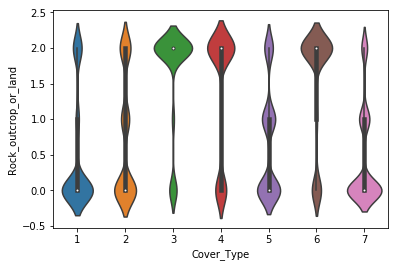

In [7]:
sns.violinplot(x='Cover_Type', y='Rock_outcrop_or_land', data=train_df)

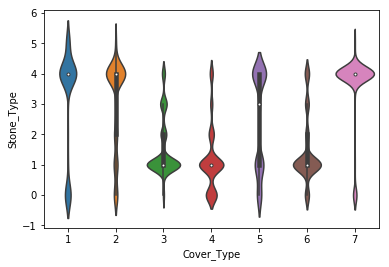

In [8]:
sns.violinplot(x='Cover_Type', y='Stone_Type', data=train_df)

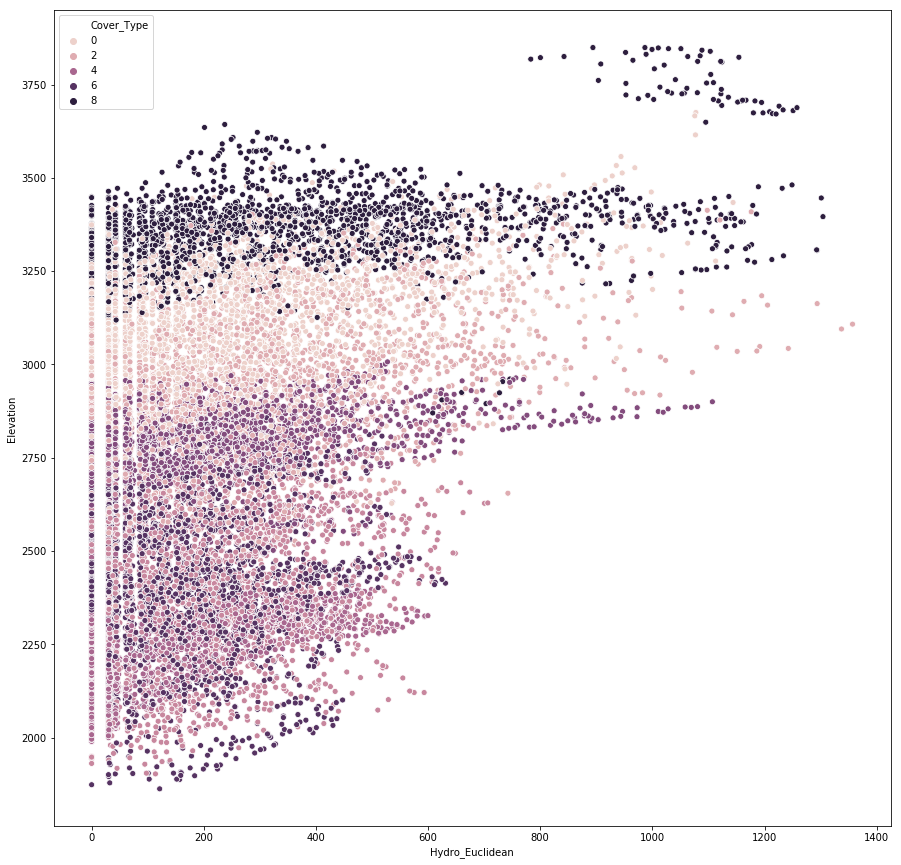

In [9]:
f, axes = plt.subplots(1, 1, figsize=(15, 15), sharex=True, sharey=True)
sns.scatterplot(x='Hydro_Euclidean', y='Elevation', 
                hue='Cover_Type', data=train_df)

We can see they are correlated, let's try to make one independant to improve our trees

In [10]:
#estimating correlation constant
temp_df = train_df[train_df["Cover_Type"]==2]

lin_reg = LinearRegression()
lin_reg.fit(temp_df['Hydro_Euclidean'].values.ravel().reshape(-1,1),temp_df['Elevation'].values.ravel().reshape(-1,1))
lin_reg.coef_

array([[0.28633801]])

In [11]:
def straighten_elevation(data):
    data['straight_elevation']=data["Elevation"]-0.25*data['Hydro_Euclidean']
    return data

train_df = straighten_elevation(train_df)
submission_df = straighten_elevation(submission_df)

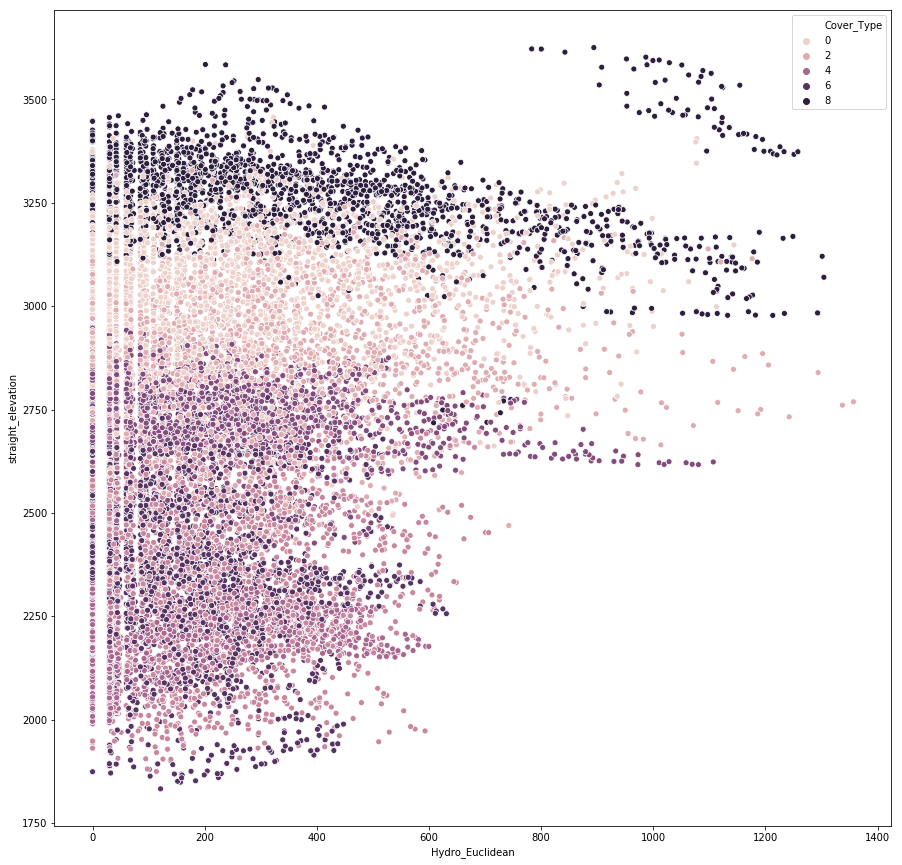

In [12]:
f, axes = plt.subplots(1, 1, figsize=(15, 15), sharex=True, sharey=True)
sns.scatterplot(x='Hydro_Euclidean', y='straight_elevation', 
                hue='Cover_Type', data=train_df)

<BarContainer object of 83 artists>

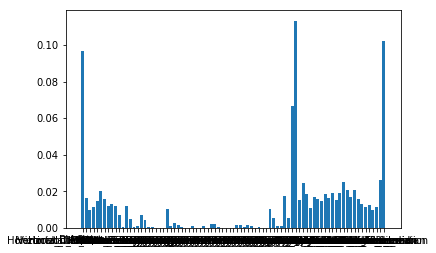

In [13]:
X = train_df.drop(['Id','Cover_Type'],axis=1)
y = train_df['Cover_Type']

forest = RandomForestClassifier(n_jobs=-1)
forest.fit(X,y)
importances = forest.feature_importances_
importance_df = pd.DataFrame()
importance_df['features']=X.columns
importance_df['importance']=importances
importance_df.sort_values('importance')
importance_df.head()
plt.bar(importance_df['features'],importance_df['importance'])

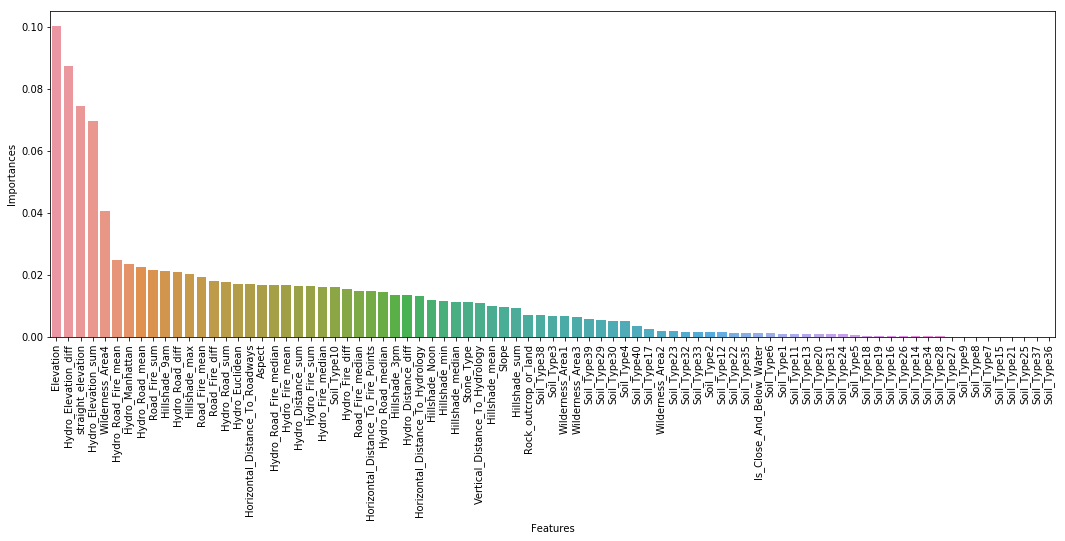

In [14]:
#clean copied value
X = train_df.drop(['Id','Cover_Type'],axis=1)
y = train_df['Cover_Type']
forest = RandomForestClassifier(n_jobs=-1)
forest.fit(X,y)
importances = pd.DataFrame({'Features': X.columns, 'Importances': forest.feature_importances_})
importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)
fig = plt.figure(figsize=(18,6))
sns.barplot(x='Features', y='Importances', data=importances)
plt.xticks(rotation='vertical')
plt.show()

Elevation related features are the most important -> add kernel features

In [15]:
def elevation_kernel_features(data):
    data['Elevation_squared']=data['Elevation']**2
    data['Elevation_log']=np.log1p(data['Elevation'])
    return data

train_df = elevation_kernel_features(train_df)
submission_df = elevation_kernel_features(submission_df)

## Normalise

do not normalise because it reduces performance

In [16]:
#normalise -> do not normalise because it reduces performance
#scaler = StandardScaler()
#value_features = ['Elevation', 'Aspect', 'Slope',
#       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
 #      'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
  #     'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
   #  'Hillshade_Total'];
#train_df[value_features] = scaler.fit(value_features);
#train_df[value_features] = scaler.fit_transform(train_df[value_features]);
#submission_df[value_features] = scaler.transform(submission_df[value_features]);
#train_df.describe()

## Create model and search for parameters

### Update X & y


In [17]:
#Update X & y after addng kernel features
X = train_df.drop(['Id','Cover_Type'],axis=1)
y = train_df['Cover_Type']

## Random forest tuning

In [18]:
rf = RandomForestClassifier(n_jobs = -1)

### Find best hyperparameters with RandomizedSearchCV

In [19]:
rf_param_grid = {'n_estimators': range(5,30),
                  'max_depth': range(3,60),
                  'min_samples_leaf':range(1,10),
                 'bootstrap':['True','False']
                 }
grid = RandomizedSearchCV(rf, rf_param_grid, cv=5, scoring ="accuracy", n_jobs = -1, n_iter = 15)
grid.fit(X,y.values.ravel())
rf = grid.best_estimator_ #assign best hyperparam values to model
print(grid.best_params_)

{'n_estimators': 18, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': 'True'}


In [20]:
#Print estimator to save chosen hyperparameters as RandomizedSearchCV isn't repeatable
print(grid.best_estimator_)

RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=18, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [21]:
#initiate model with result from grid search CV (for repeatability only)
rf = RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
                       max_depth=33, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=23, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


## Test model

 ### Kval accuracy score

In [22]:
kfold_scores = cross_val_score(rf, X, y.values.ravel(), cv=10, scoring="accuracy")
print('Using 10 Kfold evaluation, accuracy =',kfold_scores.mean())

Using 10 Kfold evaluation, accuracy = 0.7851851851851851


### Confusion matrix

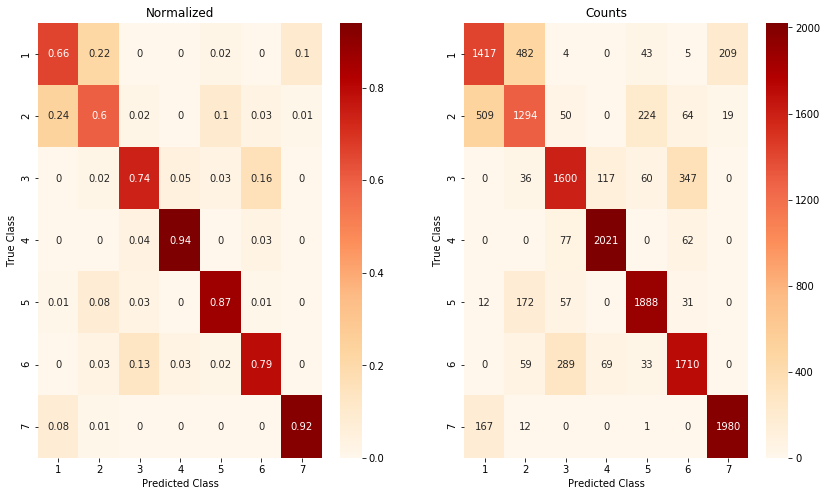

In [23]:
def cv_confusion(clf, X, y):
    prediction = cross_val_predict(clf, X, y, 
                                   cv=5, 
                                   verbose=0, 
                                   n_jobs=-1)
    
    classes = sorted(y.unique().tolist())

    conf_mat = confusion_matrix(y, prediction)
    norm_conf_mat = np.around(conf_mat / conf_mat.sum(axis=1), 2)

    fig = plt.figure(figsize=(14, 8))

    fig.add_subplot(1, 2, 1)
    ax = sns.heatmap(norm_conf_mat, annot=True, cmap='OrRd', 
                     xticklabels=classes, yticklabels=classes)
    ax.set(xlabel='Predicted Class', ylabel='True Class', title='Normalized')


    fig.add_subplot(1, 2, 2)
    ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='OrRd', 
                     xticklabels=classes, yticklabels=classes)
    ax.set(xlabel='Predicted Class', ylabel='True Class', title ='Counts')

    #plt.tight_layout()
    plt.show()
    

cv_confusion(rf,X,y)

## Make and tune neural network

In [24]:
nn = MLPClassifier(hidden_layer_sizes = (100,50,50), max_iter = 1000)
nn.fit(X,y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50, 50), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [25]:
#score not representative because no test/train split
nn.score(X,y)

0.14285714285714285

## Attempt to make a staked model

 ### Extra trees tuning

In [26]:
extra_trees = ExtraTreesClassifier()
et_param_grid={
        'n_estimators': range(10,1000),
        'max_features': range(2,40),
        'min_samples_leaf': range(1,50),
        'min_samples_split': range(2,36),
    }

et_grid = RandomizedSearchCV(extra_trees,
    et_param_grid,
    scoring='accuracy',
    cv=3,
    n_iter = 10,
    n_jobs=-1
)
et_grid.fit(X,y.values.ravel())
extra_trees = et_grid.best_estimator_
print(et_grid.best_params_)


{'n_estimators': 323, 'min_samples_split': 22, 'min_samples_leaf': 5, 'max_features': 28}


In [27]:
et_grid.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features=28, max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=5, min_samples_split=22,
                     min_weight_fraction_leaf=0.0, n_estimators=323,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [28]:
# initiating extra tress with results from randsearchcv for repeatability
extra_trees = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features=14, max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=2, min_samples_split=26,
                     min_weight_fraction_leaf=0.0, n_estimators=824,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

### Decision tree tuning

decision_tree = DecisionTreeClassifier()
dt_param_grid={
        'max_features': range(2,40),
        'min_samples_leaf': range(1,50),
        'min_samples_split': range(2,36),
    }

dt_grid = RandomizedSearchCV(decision_tree,
    dt_param_grid,
    scoring='accuracy',
    cv=5,
    n_iter = 5
)
dt_grid.fit(X,y.values.ravel())
decision_tree = dt_grid.best_estimator_
print(dt_grid.best_params_)

In [29]:
decision_tree = DecisionTreeClassifier().fit(X,y)
ada_boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=400,learning_rate=0.2,random_state=0).fit(X,y.values.ravel())
lgbm = LGBMClassifier(n_jobs = -1).fit(X,y.values.ravel())

In [30]:
kfold_scores = cross_val_score(decision_tree, X, y.values.ravel(), cv=5, scoring="accuracy")
print('decision tree accuracy =',kfold_scores.mean())
kfold_scores = cross_val_score(extra_trees, X, y.values.ravel(), cv=5, scoring="accuracy")
print('extra trees accuracy =',kfold_scores.mean())
kfold_scores = cross_val_score(ada_boost, X, y.values.ravel(), cv=5, scoring="accuracy")
print('ada boost accuracy =',kfold_scores.mean())
kfold_scores = cross_val_score(lgbm, X, y.values.ravel(), cv=5, scoring="accuracy")
print('lgbm accuracy =',kfold_scores.mean())
kfold_scores = cross_val_score(nn, X, y.values.ravel(), cv=5, scoring="accuracy")
print('nn accuracy =',kfold_scores.mean())

decision tree accuracy = 0.7187169312169313
extra trees accuracy = 0.7736111111111111
ada boost accuracy = 0.7148809523809524
lgbm accuracy = 0.7886904761904762
nn accuracy = 0.14265873015873015


In [31]:
best_model=rf #deduced from cv accuracy results above

### stacking

In [32]:
from mlxtend.classifier import StackingCVClassifier


stacked_model = StackingCVClassifier(classifiers=[rf,decision_tree,ada_boost,lgbm,extra_trees,nn],
                             meta_classifier=best_model,
                             use_probas=True,
                             drop_last_proba=False,
                             use_features_in_secondary=True,
                             verbose=0,
                             store_train_meta_features=True,
                             random_state=0,
                             n_jobs=-1)
stacked_model.fit(X,y)

StackingCVClassifier(classifiers=[RandomForestClassifier(bootstrap='True',
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=33,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=2,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         n_estimators=23,
                                                         n_jobs=-

## Create submission file

In [33]:
final_model = stacked_model

In [34]:
kfold_scores = cross_val_score(final_model, X, y.values.ravel(), cv=10, scoring="accuracy")
print('Using 10 Kfold evaluation, final model accuracy =',kfold_scores.mean())

Using 10 Kfold evaluation, final model accuracy = 0.788888888888889


In [35]:
X_submission = submission_df.drop(['Id'], axis=1)
submission_prediction = final_model.predict(X_submission)
output = pd.DataFrame({'Id': submission_df.Id,
                      'Cover_Type': submission_prediction})
output.to_csv('submission.csv', index=False);